<a href="https://colab.research.google.com/github/JorgeBennasar/Audio-Classification/blob/master/Autoregressive_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoregressive Models

# Part 1
The [Lotka-Volterra equations](https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations) describe the behavior of predator-prey relationships in a closed ecosystem. Here, I develop code to simulate the system given a set of hyperparameters and initial conditions, and visualize the trajectories of the system to gain a better understanding of the model.

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def lotka(x, y, alpha, beta, delta, gamma):
  '''Calculate the Lotka-Volterra ODE.
  
    Inputs: scalar or tensor values x and y.
    Outputs: scalar or tensor values x' and y'.
  ''' 
  x_prime = alpha * x - beta * x * y
  y_prime = delta * x * y - gamma * y

  return x_prime, y_prime

def integrate_ode(x0, y0, alpha, beta, delta, gamma, time, dt):
  '''Integrate the ODE.

    Inputs: initial conditions x0 and y0; hyperparameters
    alpha, beta, delta and gamma; total time to integrate;
    discretization step dt.

    Outputs: two tensors containing x[t] and y[t].
  '''
  x, y = [x0], [y0]

  x_prev, y_prev = x0, y0

  for t in range(int(time / dt)):
    
    x_prime, y_prime = lotka(x_prev, y_prev, alpha, beta, delta, gamma)
    x_now, y_now = x_prev + dt * x_prime, y_prev + dt * y_prime
    x.append(x_now)
    y.append(y_now)
    x_prev, y_prev = x_now, y_now

  x, y = torch.tensor(x), torch.tensor(y)

  return x, y

x, y = integrate_ode(5, 4, 0.9, 0.3, 0.8, 1, 20, 0.01)

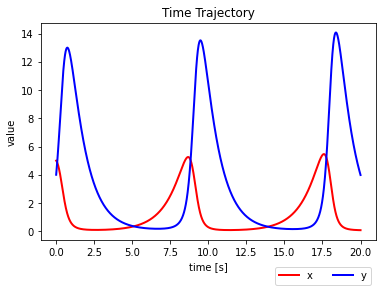

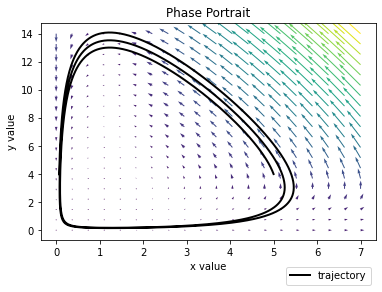

In [ ]:
def plot_results(x0, y0, alpha, beta, delta, gamma, time, dt, xmin, xmax, ymin, ymax):
  '''Plot time trajectory and phase portrait.

    Inputs: initial conditions x0 and y0; hyperparameters
    alpha, beta, delta and gamma; total time to integrate;
    discretization step dt; gradient field limits xmin, xmax, ymin, and ymax.
  ''' 
  x, y = integrate_ode(x0, y0, alpha, beta, delta, gamma, time, dt)
  x, y = x.numpy(), y.numpy()

  plt.figure()
  plt.plot(np.linspace(0, time, len(x)), x, color=[1, 0, 0], linewidth=2, label="x")
  plt.plot(np.linspace(0, time, len(x)), y, color=[0, 0, 1], linewidth=2, label="y")
  plt.legend(loc="upper right", bbox_to_anchor=(1, -0.1), ncol=2)
  plt.xlabel("time [s]")
  plt.ylabel("value")
  plt.title("Time Trajectory")

  X, Y  = np.meshgrid(np.linspace(xmin, xmax, 20), np.linspace(ymin, ymax, 20))
  X.reshape(-1)
  Y.reshape(-1)
  U, V = lotka(X, Y, alpha, beta, delta, gamma)

  plt.figure()
  plt.plot(x, y, color=[0, 0, 0], linewidth=2, label="trajectory")
  plt.quiver(X, Y, U, V, np.hypot(U, V), angles="xy")
  plt.legend(loc="upper right", bbox_to_anchor=(1, -0.1), ncol=2)
  plt.xlabel("x value")
  plt.ylabel("y value")
  plt.title("Phase Portrait")

plot_results(5, 4, 0.9, 0.3, 0.8, 1, 20, 0.01, 0, 7, 0, 14)

# Part 2

In a given dataset, researchers have measured the density of a certain predator and prey in a real savannah, but the equipment was unreliable so the data has gaps as well as noise.

Here, I train an [MLP](https://en.wikipedia.org/wiki/Multilayer_perceptron) to regress the full observed trajectory from the measured data. The model takes the current time as an input, and predicts the values of `x` and `y` at that time based only on the measured data.

In [ ]:
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
class Net(nn.Module):
  '''Model to regress 2d time series values given a scalar input.
  '''
  def __init__(self, hidden_dimensions):
    '''Initializes the class.

      Inputs: hidden dimensions.
    '''
    super(Net, self).__init__()
    
    layers = [nn.Linear(1, hidden_dimensions[0]), nn.ReLU()]

    for i in range(len(hidden_dimensions) - 1):

      layers.append(nn.Linear(hidden_dimensions[i], hidden_dimensions[i+1]))
      layers.append(nn.ReLU())
      
    layers.append(nn.Linear(hidden_dimensions[-1], 2))
    self.layers = nn.Sequential(*layers)

  def forward(self, t):
    '''Forward of the model.

      Inputs: time.

      Outputs: x and y predictions.
    '''
    pred = self.layers(t)

    return pred

In [ ]:
class TimeSeriesDataset(torch.utils.data.Dataset):
  '''Time series dataset.
  '''
  def __init__(self, csv_file):
    '''Initializes the class.

      Inputs: csv file name.
    '''
    df = pd.read_csv(os.path.join("/content/drive/MyDrive/Colab Notebooks/", csv_file))

    df = df.iloc[df[["x"]]._convert(numeric=True).dropna().index]
    df.reset_index(inplace = True, drop = True)
    df = df.iloc[df[["y"]]._convert(numeric=True).dropna().index]
    df.reset_index(inplace = True, drop = True)

    self.length = df.shape[0]
    self.t = df[["t"]].values.squeeze().astype("float32")
    self.x = df[["x"]].values.squeeze().astype("float32")
    self.y = df[["y"]].values.squeeze().astype("float32")

  def __len__(self):
    '''Returns length of the dataset.

      Outputs: dataset length.
    '''
    return self.length

  def __getitem__(self, idx):
    '''Returns data at a given index.

      Inputs: index.

      Outputs: input (time) and target (x and y) values at the given index.
    '''
    input = torch.tensor([self.t[idx]])
    target = torch.tensor([self.x[idx], self.y[idx]])

    return input, target 

In [ ]:
train_dataset = TimeSeriesDataset('data.csv')
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

net = Net([100, 200, 100])
net.to(device)

loss_function = nn.MSELoss(reduction='none')
loss_function.to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=1e-3, betas=(0.9, 0.999))

In [ ]:
for epoch in range(1000):

  for i, data in enumerate(train_loader, 0):

    input, target = [x.to(device) for x in data]
    pred = net.forward(input)
    loss = loss_function(pred, target).sum()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Text(0.5, 1.0, 'Predicted VS Target')

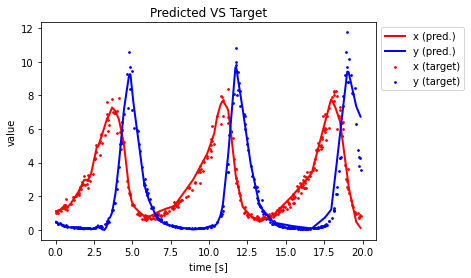

In [ ]:
t, x, y = train_dataset.t, train_dataset.x, train_dataset.y

time = np.linspace(min(t), max(t), 10000).astype("float32")
x_pred = []
y_pred = []

for i in range(len(time)):
  
  pred = net(torch.tensor([time[i]]).to(device)).detach().cpu().numpy()
  x_pred.append(pred[0])
  y_pred.append(pred[1])

plt.figure()
plt.scatter(t, x, color=[1, 0, 0], s=3, label="x (target)")
plt.plot(time, x_pred, color=[1, 0, 0], linewidth=2, label="x (pred.)")
plt.scatter(t, y, color=[0, 0, 1], s=3, label="y (target)")
plt.plot(time, y_pred, color=[0, 0, 1], linewidth=2, label="y (pred.)")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), ncol=1)
plt.xlabel("time [s]")
plt.ylabel("value")
plt.title("Predicted VS Target")

## Questions
Please answer the questions about the exercise below as a text cell. A few sentences answer per question is enough, no need to write a long essay.
  
- a) Roughly, how many parameters does the neural network you defined above have? How did you estimate that number?
- b) How does changing the batch size affect the optimization procedure?
- c) What optimizer did you choose and why? Explain its most important hyperparameters.
- d) What difficulties did you face when processing the dataset? How did you resolve them?
- e) How did you find the hyperparameters that gave you the best result? What would you have done if you had more time?
- f) In this exercise, we trained an MLP to regress the data from a single time point. This corresponds to assuming the source function is markovian. What would we do differently if the function under study were non-markovian?
- g) In this exercise, we did not check for overfitting. How would you change the code above to test for that possibility?


a) We can calculate the number of parameters $N$ of the neural network with the formula:

$N = N_w + N_b$

The number of weights, $N_w$, can be determined by multiplying the input and output dimensions of each linear layer and then adding everything up: 

$N_w = 1 * 100 + 100 * 200 + 200 * 100 + 100 * 2 = 40300$

The number of biases, $N_b$, can be calculated by summing the output dimensions of the linear layers of the network: 

$N_b = 100 + 200 + 100 + 2 = 402$

The total number of parameters would then be: 

$N = 40300 + 402 = 40702$

b) Changing the batch size affects the optimization procedure in many ways, including:

*   Increasing the batch size reduces the number of updates of the model's parameters for a fixed number of epochs. To compensate for this, the learning rate should be increased accordingly. In fact, while introducing some learning rate decay during training is common practice, gradually increasing the batch size would also have a similar effect, reducing the effect of the updates in later stages of training.

*   Increasing the batch size reduces computing power, as you skip part of the cost associated with moving the data from RAM/disk to GPU.

*   Increasing the batch size may have a negative effect on gradient descent, as the model may get stuck on local minima more easily. Smaller batch sizes are thought to generalize the model, helping it to find the global minima. In other words, we could say that training with smaller batch sizes makes the model more "exploratory".

c) I used the well-known Adam, which is one (if not the) state-of-the-art model optimizer. It has many advantages, including:

*   It is computationally efficient.

*   It is memory efficient.

*   Default hyperparameter values generally do well.

Its main hyperparameters are:

*   The learning rate, $\alpha$, determines the step size at each iteration.

*   Beta 1, $\beta_1$, controls the moving average of the gradients of the current iteration and past ones (see Momentum).

*   Beta 2, $\beta_2$, controls the moving average of the squares of the gradients (see RMSProp).

d) I just eliminated the gaps in the dataset by removing the samples that had incomplete data.

e) I tried different network configurations (this is, the number of hidden layers and neurons), different optimizers (SGD and Adam), several learning rates and betas, various batch sizes, and several numbers of epochs. If I had more time, I would have:

*   Included a validation dataset to make sure that the network is training optimally and to check for possible overfitting.

*   Experimented with different model structures (e.g. other non-linearities or types of layers).

*   Played with some regularization techniques, such as dropout, also to avoid overfitting.

f) If the function under study was non-markovian I would have implemented some kind of recurrent neural network (RNN) such as a long short-term memory (LSTM) network. These kinds of networks have a time component that allows them to remember the past (and in some cases, also the future) and use this knowledge to make more precise predictions when the output is also a function of other time points aside from the present.

g) There are many ways to tackle overfitting:

*   Most evidently, adding a validation (and/or test) set.

*   Including some regularization techniques, such as dropout or L2 regularization.

*   Increasing the number of samples in the dataset (although not possible in this case).

# Part 3

In this section, I train a generative model of the above Lotka-Volterra equations. While there are many approaches to create a generative model, here I focus on creating an autoregressive model, i.e. $f_{t+1} = g(f_t, f_{t-1}, ...)$ where $g$ is a suitable neural network architecture.

In [ ]:
!pip install x-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from x_transformers import AutoregressiveWrapper, TransformerWrapper, Decoder

n_bins = 20
n_tokens = n_bins * n_bins

def convert_to_tokens(x, y, n_bins):

  digit_x = np.digitize(np.log(x), np.linspace(-3, 3, n_bins))
  digit_y = np.digitize(np.log(y), np.linspace(-3, 3, n_bins))

  return digit_x * n_bins + digit_y

model = AutoregressiveWrapper(
    TransformerWrapper(
        num_tokens = n_tokens,
        max_seq_len = 1024,
        attn_layers = Decoder(
            dim = 10,
            depth = 6,
            heads = 8
            )
        )
    ).cuda()

optimizer = optim.Adam(model.parameters(), lr=3e-3)

In [ ]:
for epoch in range(100):

  for i in range(200):

    x0, y0 = np.random.uniform(0.1, 5), np.random.uniform(0.1, 5)
    x, y = integrate_ode(x0, y0, 0.9, 0.3, 0.8, 1, 10, 0.01)
    inputs = convert_to_tokens(x, y, n_bins)
    inputs = torch.tensor(inputs).unsqueeze(0).cuda()
    loss = model(inputs)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [ ]:
x0, y0 = 5, 4
time = 10
dt = 0.01

inputs = convert_to_tokens(x0, y0, n_bins)
sample = model.generate(torch.tensor([inputs]).cuda(), int(time / dt)).detach().cpu().numpy()

Text(0.5, 1.0, 'Predicted VS Target')

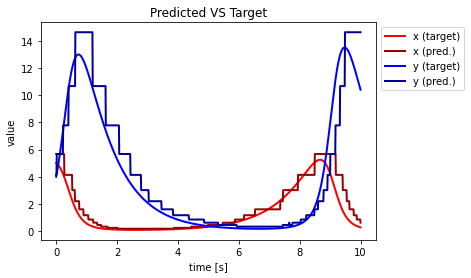

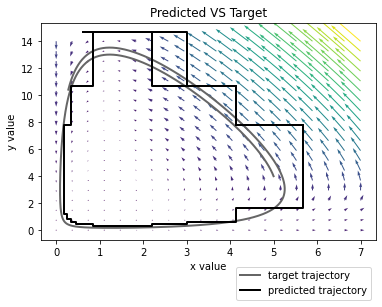

In [ ]:
def reverse_tokens(inputs, n_bins):

  digit_y = inputs % n_bins
  digit_x = ((inputs - digit_y) / n_bins).astype("int")
  x = np.exp(np.linspace(-3, 3, n_bins)[digit_x])
  y = np.exp(np.linspace(-3, 3, n_bins)[digit_y])

  return x, y

x, y = integrate_ode(x0, y0, 0.9, 0.3, 0.8, 1, time, dt)
x_pred, y_pred = reverse_tokens(sample, n_bins)

plt.figure()
plt.plot(np.linspace(0, time, len(x)), x, color=[1, 0, 0], linewidth=2, label="x (target)")
plt.plot(np.linspace(0, time, len(x_pred)), x_pred, color=[0.6, 0, 0], linewidth=2, label="x (pred.)")
plt.plot(np.linspace(0, time, len(x)), y, color=[0, 0, 1], linewidth=2, label="y (target)")
plt.plot(np.linspace(0, time, len(y_pred)), y_pred, color=[0, 0, 0.6], linewidth=2, label="y (pred.)")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), ncol=1)
plt.xlabel("time [s]")
plt.ylabel("value")
plt.title("Predicted VS Target")

X, Y  = np.meshgrid(np.linspace(0, 7, 20), np.linspace(0, 14, 20))
X.reshape(-1)
Y.reshape(-1)
U, V = lotka(X, Y, 0.9, 0.3, 0.8, 1)

plt.figure()
plt.plot(x, y, color=[0.4, 0.4, 0.4], linewidth=2, label="target trajectory")
plt.plot(x_pred, y_pred, color=[0, 0, 0], linewidth=2, label="predicted trajectory")
plt.quiver(X, Y, U, V, np.hypot(U, V), angles="xy")
plt.legend(loc="upper right", bbox_to_anchor=(1, -0.1), ncol=1)
plt.xlabel("x value")
plt.ylabel("y value")
plt.title("Predicted VS Target")

## Questions
- Please explain which bugs you fixed and why they were a problem.

The main changes I introduced in the code are:

*   In the function "convert_to_tokens", I changed the output so that each tokenized index corresponds to one position in the x-y plane.

*   During training, I set the gradients to zero before each backward pass, as PyTorch accumulates the gradients if this is not done! I did this because we want the network to forget the old gradients that were already used to update the model.

*   I also modified the code to directly train the autoregressive model (AutoregressiveWrapper()) instead of solely the transformer (TransformerWrapper()). I have not worked with transformers much until now, but doing it this way was more intuitive for me, as the objective is to train the autoregressive generative model.

*   The rest of the changes were only for training optimization and visualization purposes (learning rate, number of epochs, logs...).